In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import numpy as np
import json
from tqdm import tqdm
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
else:
    device = torch.device("cpu")
    print("Using CPU.")

Using GPU: NVIDIA GeForce GTX 1080 Ti
Number of GPUs available: 1


Load the Train dataset

In [3]:
ROOT_DIR = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset'

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

### Load Pre-trained DINOv2 Model

In [4]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)

Using cache found in /home/etaylor/.cache/torch/hub/facebookresearch_dinov2_main
/home/etaylor/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/etaylor/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/etaylor/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [43]:
14*5

70

In [55]:
from PIL import Image

# Transformation for images, including conversion to HSV
transform_image = T.Compose([
    T.Resize((56, 56)),  # Resize to a slightly larger size
    T.ToTensor(),  # Convert to tensor
])

In [56]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}
    
    with torch.no_grad():
        for i, file in enumerate(tqdm(files)):
            embeddings = dinov2_vits14(load_image(file).to(device))

            all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

Get the embeddings for the Images


In [57]:
embeddings = compute_embeddings(files)

100%|██████████| 2191/2191 [00:16<00:00, 128.90it/s]


### Check for clusters in 2d

In [74]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


# Load embeddings from file
with open("all_embeddings.json", "r") as f:
    all_embeddings = json.load(f)

# Extract embeddings and corresponding labels
embeddings = np.array([embedding[0] for embedding in all_embeddings.values()])
embedding_files = list(all_embeddings.keys())
embedding_labels = [labels[file] for file in embedding_files]

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Perform t-SNE with higher perplexity
tsne = TSNE(n_components=2, perplexity=50, n_iter=300)
tsne_result = tsne.fit_transform(embeddings)

# Perform UMAP
umap_result = umap.UMAP(n_components=2).fit_transform(embeddings)

# Encode labels for LDA
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(embedding_labels)

# Perform LDA
lda = LDA(n_components=2)
lda_result = lda.fit_transform(embeddings, encoded_labels)

# Define custom colors
color_map = {
    'clear': 'silver',
    'cloudy': 'white',
    'amber': 'orange'
}

# Plotting function with custom colors and black frames
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(8, 5))
    for label in set(labels):
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(
            embeddings[indices, 0], embeddings[indices, 1], 
            label=label, 
            c=color_map[label], 
            edgecolors='black'
        )
    plt.legend()
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

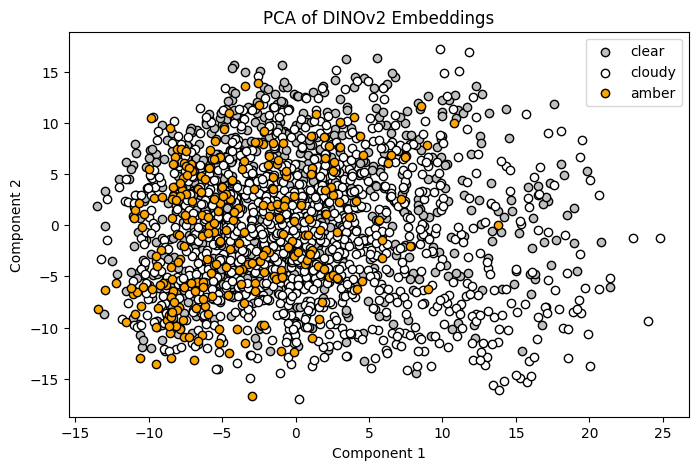

In [71]:
# Plot PCA results
plot_embeddings(pca_result, embedding_labels, 'PCA of DINOv2 Embeddings')

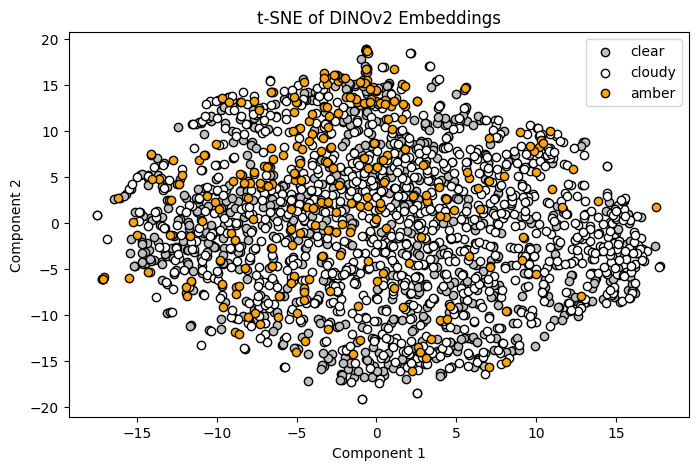

In [72]:
# Plot t-SNE results
plot_embeddings(tsne_result, embedding_labels, 't-SNE of DINOv2 Embeddings')

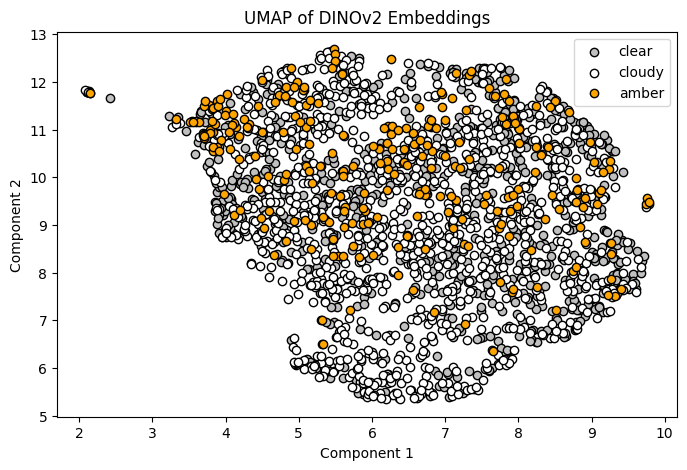

In [73]:
# Plot UMAP results
plot_embeddings(umap_result, embedding_labels, 'UMAP of DINOv2 Embeddings')

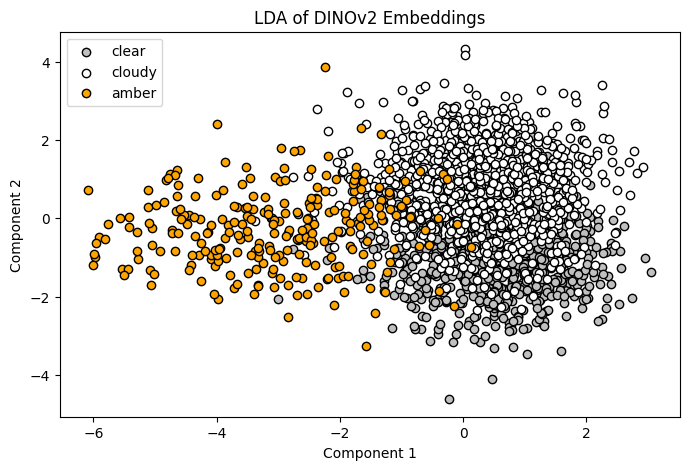

In [75]:
# Plot LDA results
plot_embeddings(lda_result, embedding_labels, 'LDA of DINOv2 Embeddings')

Prepare the data for classification models

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


y = [labels[file] for file in files]

embedding_list = list(embeddings.values())

# Encode labels in a specific order
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['clear', 'cloudy', 'amber'])  # Specify the desired order

# Transform labels to the specified order
y_encoded = label_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(np.array(embedding_list).reshape(-1, 384), y_encoded, test_size=0.2, random_state=42)


In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(gamma='scale'),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500),
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100),
    "CatBoost": cb.CatBoostClassifier(n_estimators=100, verbose=0),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "Linear SVC": LinearSVC(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier()
}

results = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')

    precision_micro = precision_score(y_test, y_pred, average='micro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)


    results[name] = {
        "accuracy": accuracy,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        'confusion_matrix': cm,
    }

    # Print classification report
    print(f"Classification Report for {name}:")
    # Print all results
    for metric, value in results[name].items():
        print(f"{metric}: {value}")


Classification Report for Logistic Regression:
accuracy: 0.6537585421412301
precision_macro: 0.6597975768321512
recall_macro: 0.6540939214747022
precision_micro: 0.6537585421412301
recall_micro: 0.6537585421412301
confusion_matrix: [[113  53   5]
 [ 67 142  10]
 [ 12   5  32]]
Classification Report for SVM:
accuracy: 0.6514806378132119
precision_macro: 0.6532085561497326
recall_macro: 0.5262634734259001
precision_micro: 0.6514806378132119
recall_micro: 0.6514806378132119
confusion_matrix: [[114  55   2]
 [ 53 164   2]
 [ 20  21   8]]
Classification Report for Random Forest:
accuracy: 0.6241457858769932
precision_macro: 0.6965856606102293
recall_macro: 0.4918831106904029
precision_micro: 0.6241457858769932
recall_micro: 0.6241457858769932
confusion_matrix: [[101  70   0]
 [ 51 167   1]
 [ 17  26   6]]
Classification Report for K-Nearest Neighbors:
accuracy: 0.5603644646924829
precision_macro: 0.5767028701526518
recall_macro: 0.4698068284431452
precision_micro: 0.5603644646924829
recall_

/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report for AdaBoost:
accuracy: 0.5353075170842825
precision_macro: 0.5229086229086229
recall_macro: 0.4762030102435911
precision_micro: 0.5353075170842825
recall_micro: 0.5353075170842825
confusion_matrix: [[ 92  74   5]
 [ 81 128  10]
 [ 12  22  15]]
Classification Report for XGBoost:
accuracy: 0.6492027334851936
precision_macro: 0.6793049130974861
recall_macro: 0.5644231256549723
precision_micro: 0.6492027334851936
recall_micro: 0.6492027334851936
confusion_matrix: [[108  61   2]
 [ 55 161   3]
 [ 18  15  16]]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 384
[LightGBM] [Info] Start training from score -0.944951
[LightGBM] [Info] Start training from score -0.705784
[LightGBM] [Info] Start training from score -2.140637
Classification 

/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Classification Report for Quadratic Discriminant Analysis:
accuracy: 0.5740318906605922
precision_macro: 0.44356849268917187
recall_macro: 0.40065155277844533
precision_micro: 0.5740318906605922
recall_micro: 0.5740318906605922
confusion_matrix: [[ 40 131   0]
 [  7 212   0]
 [  4  45   0]]


/home/etaylor/.conda/envs/fastai_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report for Linear SVC:
accuracy: 0.6104783599088838
precision_macro: 0.6060079966329966
recall_macro: 0.636009462665143
precision_micro: 0.6104783599088838
recall_micro: 0.6104783599088838
confusion_matrix: [[126  32  13]
 [ 92 109  18]
 [ 13   3  33]]
Classification Report for Decision Tree:
accuracy: 0.55125284738041
precision_macro: 0.49278207172944016
recall_macro: 0.5102700216512144
precision_micro: 0.55125284738041
recall_micro: 0.55125284738041
confusion_matrix: [[ 85  60  26]
 [ 63 137  19]
 [ 17  12  20]]


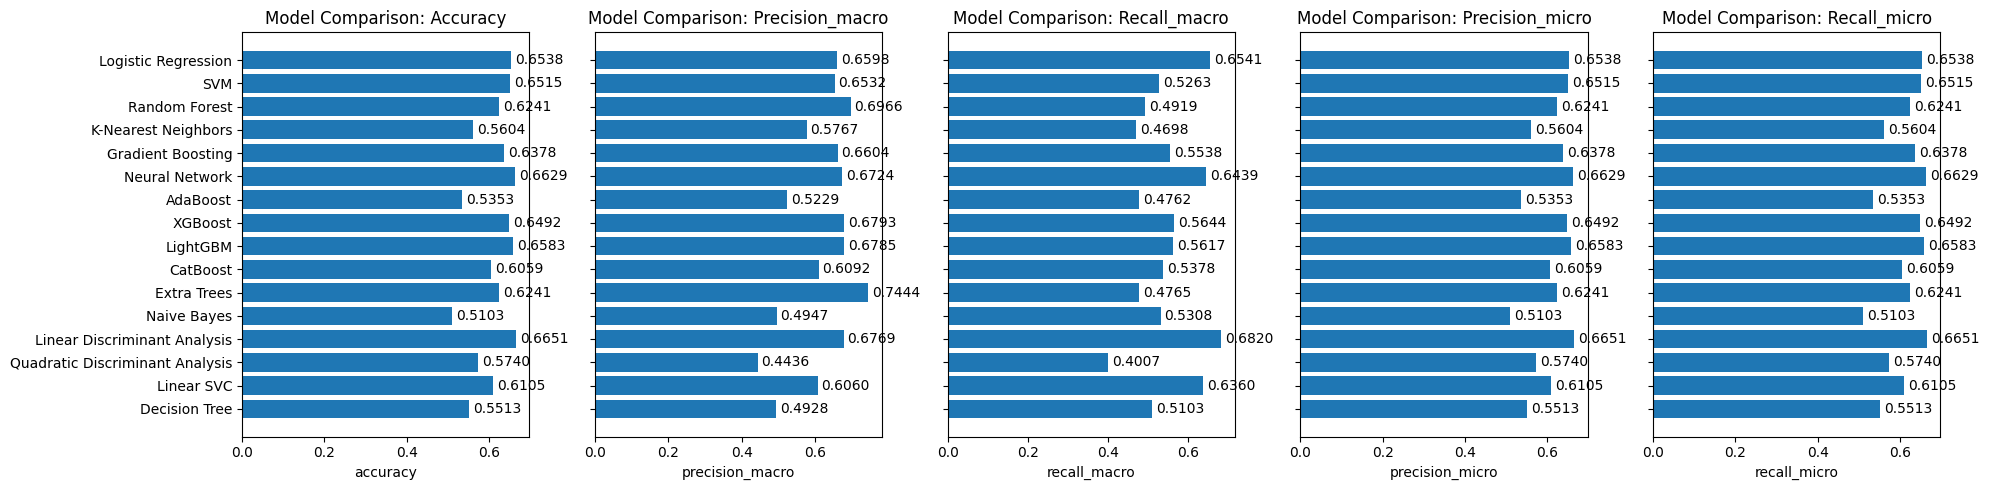

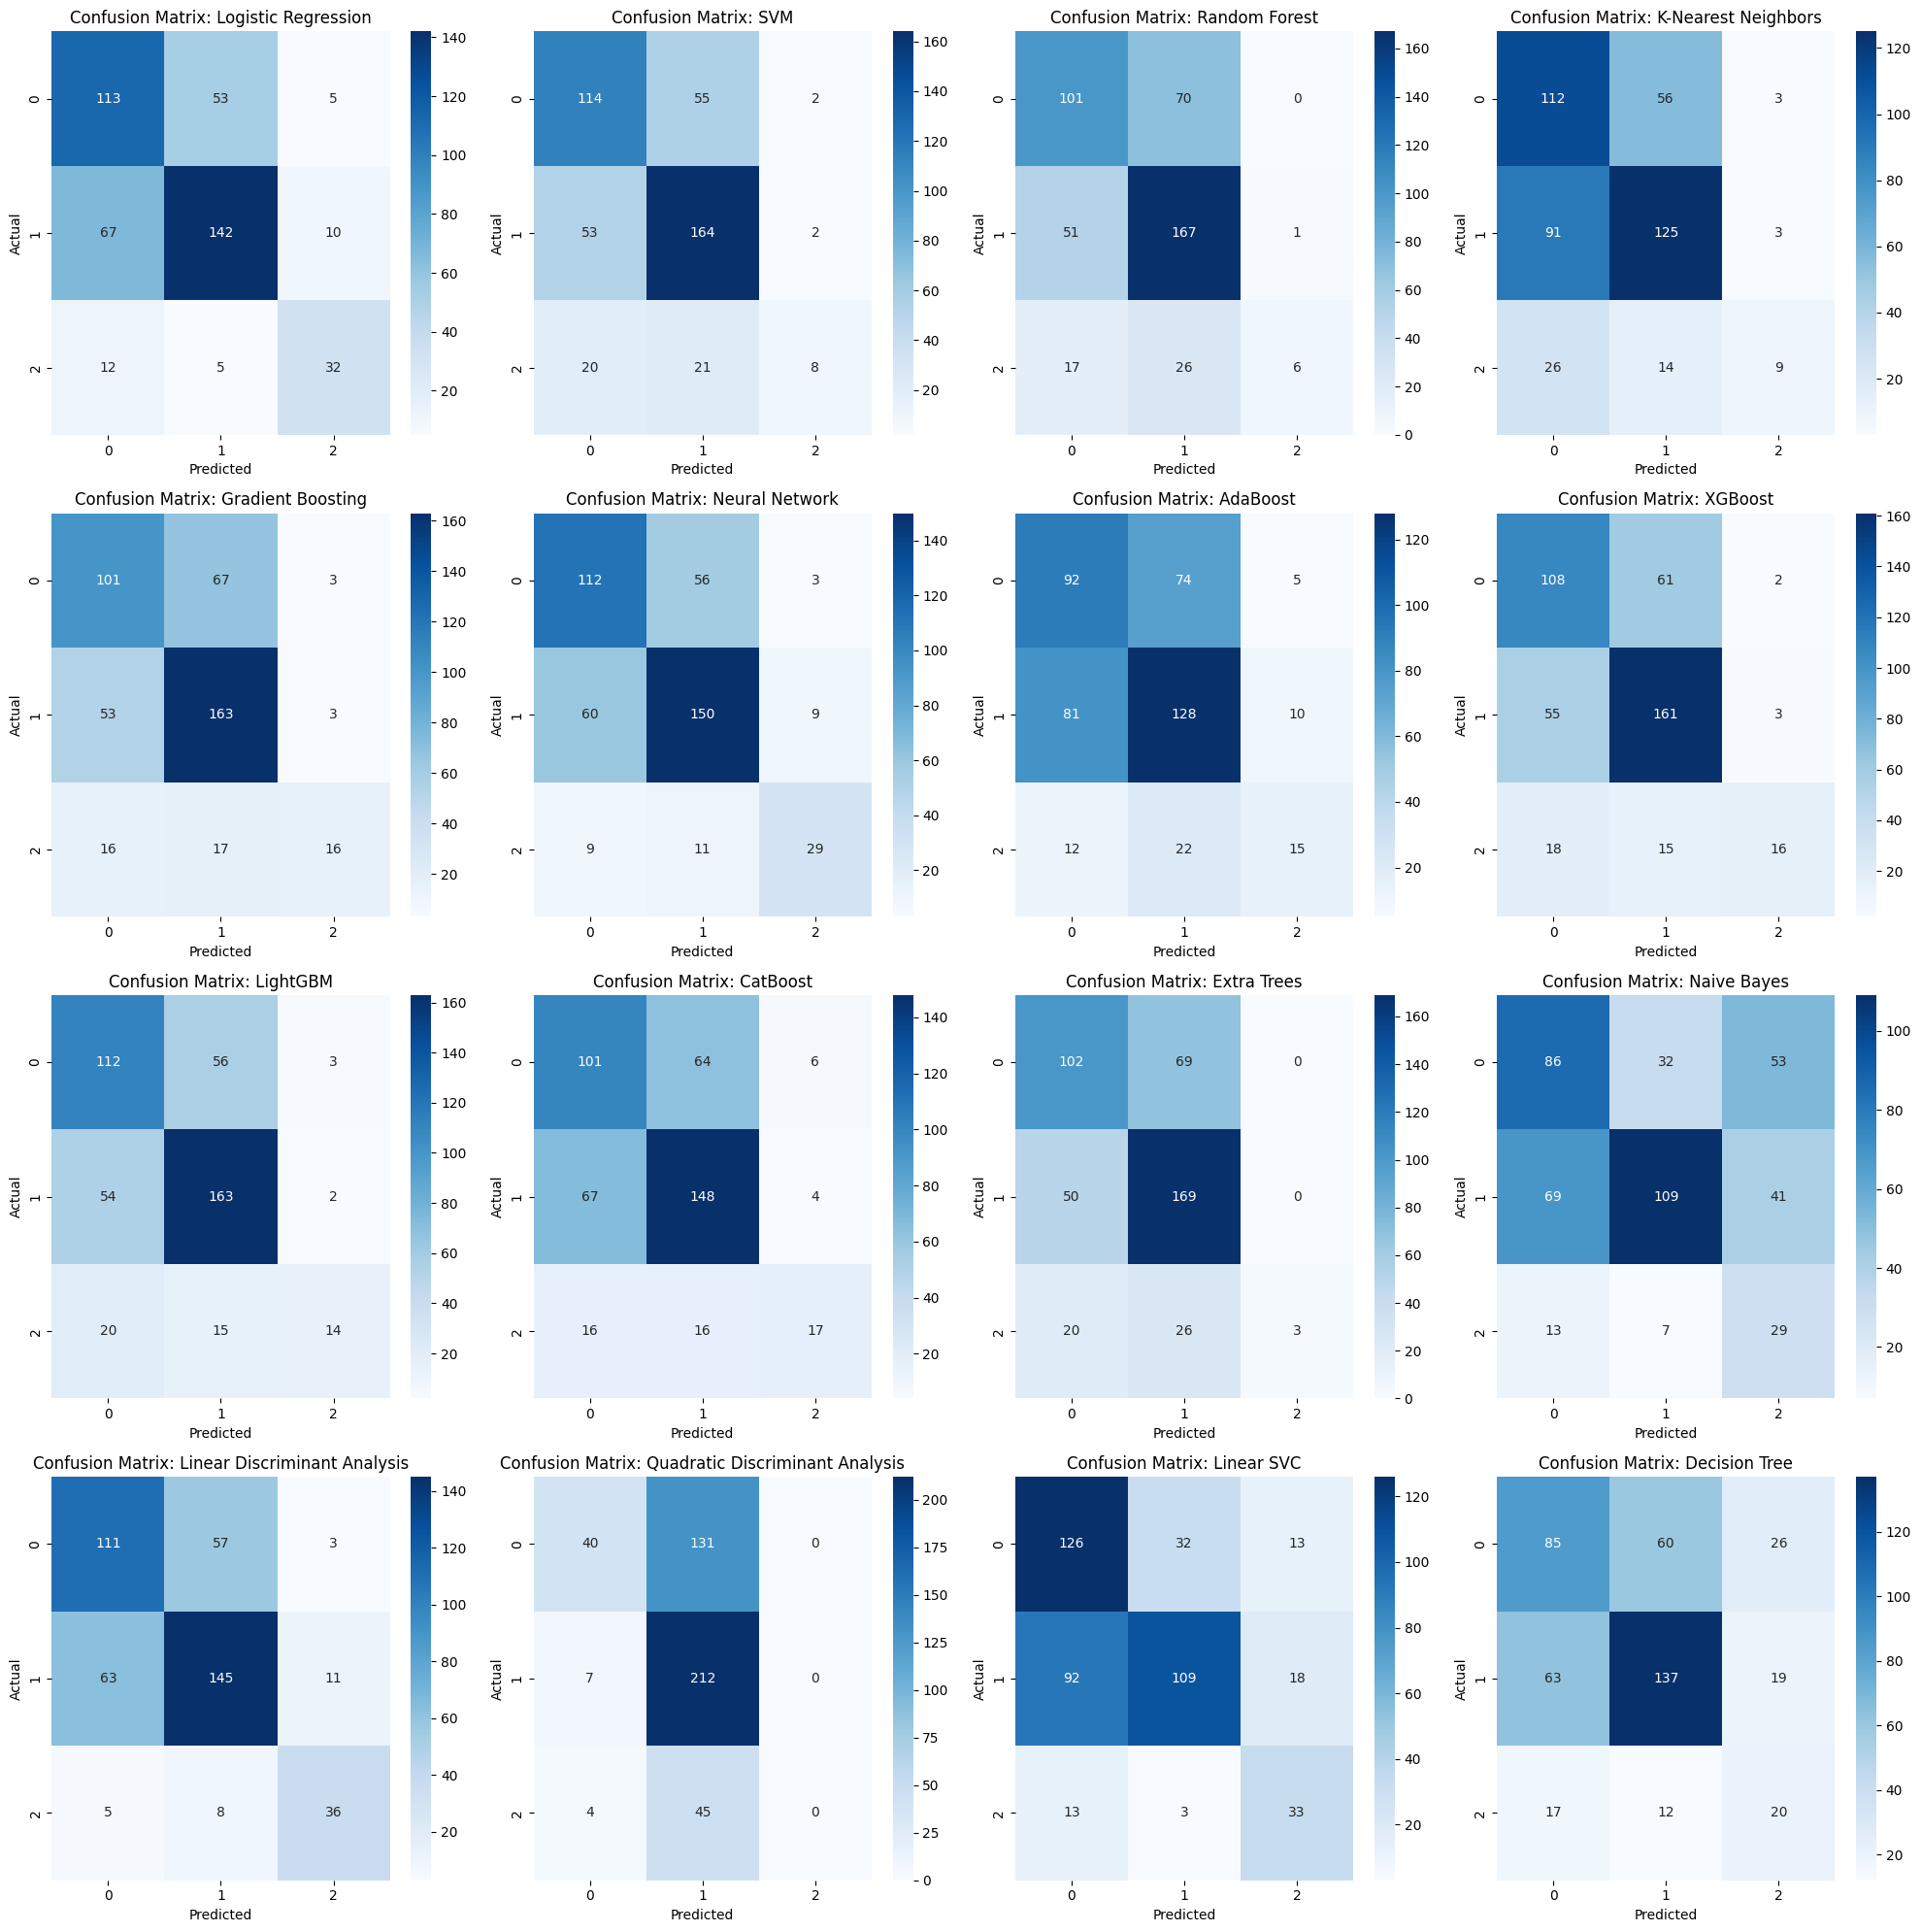

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Assuming 'results' dictionary is already populated with metrics for each model

# Extract metrics for plotting
metrics_to_plot = ["accuracy", "precision_macro", "recall_macro", "precision_micro", "recall_micro"]

# Initialize plot for metrics
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(1, num_metrics, figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics_to_plot):
    metric_values = [metrics[metric] for metrics in results.values()]
    models = list(results.keys())
    y_pos = np.arange(len(models))

    axes[i].barh(y_pos, metric_values, align='center')
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(models)
    axes[i].invert_yaxis()  # Invert y-axis to have the best model on top
    axes[i].set_xlabel(metric)
    axes[i].set_title(f'Model Comparison: {metric.capitalize()}')

    # Annotate bars with values
    for j in range(len(models)):
        axes[i].text(metric_values[j] + 0.01, y_pos[j], f'{metric_values[j]:.4f}', va='center')

plt.tight_layout()
plt.show()

# Plot all confusion matrices in a 4x4 grid
num_models = len(results)
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()  # Flatten the 2D array of axes

for i, (name, metrics) in enumerate(results.items()):
    cm = metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix: {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
